<a href="https://colab.research.google.com/github/margaret-tk/APS360-AI/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import torch
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# location on Google Drive
master_path = '/content/drive/My Drive/'

classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

data_transform = transforms.Compose([transforms.RandomResizedCrop(64), 
                                      transforms.ToTensor()])

dataset = datasets.ImageFolder(master_path+'dataset/imgs', transform=data_transform)
subset = datasets.ImageFolder(master_path+'aps360_subset', transform=data_transform)

In [0]:
print(len(dataset))
#train_index+ val_index+ test_index+ extra_index
import pandas as pd
pd_dataset = pd.Series(dataset.targets)
pd_dataset.value_counts()

27004


2    3004
9    3000
7    3000
1    3000
0    3000
8    2500
6    2500
4    2500
3    2500
5    2000
dtype: int64

In [0]:
train_index, val_index, test_index, extra = int(0.05*len(dataset)), int(0.01*len(dataset)), int(0.01*len(dataset)), int(0.93*len(dataset))+1 
train, val, test, extra = torch.utils.data.random_split(dataset, [train_index,val_index,test_index, extra])
#train_index + val_index + test_index + extra

In [0]:
#train_index, val_index, test_index = int(0.6*len(dataset))+2, int(0.2*len(dataset)), int(0.2*len(dataset))
#train, val, test = torch.utils.data.random_split(dataset, [train_index,val_index,test_index])

In [0]:
len(train_loader.dataset)

NameError: ignored

In [0]:
# define dataloader parameters
batch_size  = 20
num_workers = 1

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

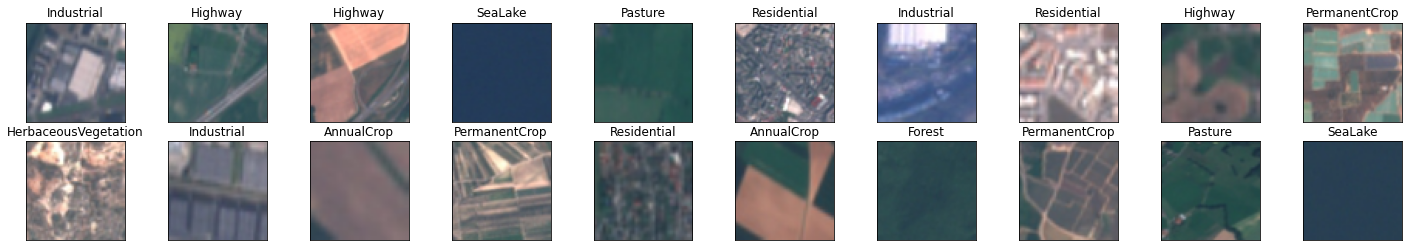

In [0]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 
# convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [0]:
torch.manual_seed(1)
dataiter = iter(train_loader)
images, labels = dataiter.next()
alexNet = models.alexnet(pretrained=True)
features = alexNet.features(images)
features.shape

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


torch.Size([20, 256, 1, 1])

In [0]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 1 * 1, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 256 * 1 * 1) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
#Convolutional Neural Network Architecture
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)   
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(20, 10)            #(32, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 256 * 7 * 7)             #(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        imgs = alexNet.features(imgs) #SLOW
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [0]:
def train(model, data, batch_size=20, num_epochs=15):

  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)

  criterion = nn.CrossEntropyLoss()     
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


  iters, losses, train_acc, val_acc = [], [], [], []

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
      for imgs, labels in iter(train_loader):
          
          imgs = features = alexNet.features(imgs)       
              
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch

          # save the current training information
          iters.append(n)
          losses.append(float(loss)/batch_size)             # compute *average* loss
          train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
          val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
          n += 1

      plt.title("Training Curve")
      plt.plot(iters, train_acc, label="Train")
      plt.plot(iters, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Training Accuracy for Epoch {}: {}".format(epoch, train_acc[-1]))
      print("Validation Accuracy for Epoch {}: {}".format(epoch, val_acc[-1]))
    
    
    
  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [0]:
ANNmodel = ANNClassifier()

In [0]:
CNNmodel = CNNClassifier()

In [0]:
train(CNNmodel, train_loader, CNN = True)

RuntimeError: ignored

In [0]:
ANNmodel = ANNClassifier()
train(ANNmodel, train_loader , batch_size=20, num_epochs=15)

TypeError: ignored

# SVM


In [0]:
dataiter = iter(train_loader)
train_images, train_labels = dataiter.next()
train_images = train_images.numpy()
#val
dataiter = iter(val_loader)
val_images, val_labels = dataiter.next()
val_images = val_images.numpy()

train_images = np.reshape(train_images, (train_images.shape[0], -1))
val_images = np.reshape(val_images, (val_images.shape[0], -1))

In [0]:
from sklearn import svm, metrics

clf = svm.LinearSVC()
clf.fit(train_images,train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
y_pred = clf.predict(val_images)

array([9, 5, 5, 1, 5, 9, 9, 8, 9, 1, 5, 1, 1, 9, 5, 5, 5, 5, 8, 1])

In [0]:
print("Classification report for - \n{}:\n{}\n".format(clf, metrics.classification_report(val_labels, y_pred)))

Classification report for - 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.40      1.00      0.57         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2

    accuracy                           0.10        20
   macro avg       0.04      0.10      0.06        20
weighted avg       0.04      0.10   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
